In [3]:
from glob import glob
from natsort import natsorted
import functions as ft
import numpy as np
import matplotlib.pyplot as plt
import matplotlibcolors
from scipy.signal import welch
plt.style.use('matplotlibrc')

%matplotlib widget

In [4]:
def bin2mat(file_path):
    data = np.fromfile(file_path, dtype='>f8', count=-1)
    data = data.reshape((-1, 2))

    I = data[:, 0]
    Q = data[:, 1]

    # From I and Q data to Radius/Magnitude and Phase
    r = np.sqrt(I**2 + Q**2)
    I /= np.mean(r) # Normalize I to 1
    Q /= np.mean(r) # Normalize Q to 1
    R = np.sqrt(I**2 + Q**2)

    P = np.arctan2(Q, I) 
    P = np.pi - P % (2 * np.pi) # Convert phase to be taken from the negative I axis
    return R, P


def logsmooth(fs, sxx):
    # Number of points per decade
    points_per_decade = 10

    # Define logarithmic bins
    log_min = np.log10(fs[1:].min())
    log_max = np.log10(fs.max())
    log_bins = np.logspace(log_min, log_max, int((log_max - log_min) * points_per_decade))

    # Bin the data
    binned_frequencies = []
    binned_powers = []

    for i in range(len(log_bins) - 1):
        # Find indices of frequencies within the current bin
        bin_indices = (fs >= log_bins[i]) & (fs < log_bins[i + 1])
        
        # Calculate the mean frequency and power spectrum value for the bin
        if np.any(bin_indices):
            binned_frequencies.append(np.mean(fs[bin_indices]))
            binned_powers.append(np.mean(sxx[bin_indices]))

    # Convert to arrays
    binned_frequencies = np.array(binned_frequencies)
    binned_powers = np.array(binned_powers)
    return binned_frequencies, binned_powers


def get_noise_psd(file, wl=256, fs=1e6):
    _, phase = bin2mat(file)
    phase -= np.mean(phase)
    fxx, nxx = welch(phase, fs=int(fs), nperseg=wl, window='flattop', return_onesided=True)
    return logsmooth(fxx, nxx)

In [5]:
dir = r"Z:\KIDonSun\experiments\Entropy ADR\LT377w5chip2_NbTiNhyb-filtertest-20251111\6KIDs 4Pread 25 mK laser off\TD_Power/"
files = natsorted(glob(dir + '*TDvis0*.bin'))[3::3]
dir = r"Z:\KIDonSun\experiments\Entropy ADR\LT377w5chip2_NbTiNhyb-filtertest-20251107\6KIDs 3Pread 25 mK laser off\TD_Power/"
files_trim = natsorted(glob(dir + '*TDvis0*.bin'))[3::3]
dir = r"Z:\KIDonSun\experiments\Entropy ADR\LT377W5Chip2_20251018\25 mK noise laser off -39dB\TD_Power/"
files_lens = natsorted(glob(dir + '*TDvis0*.bin'))[3::3]

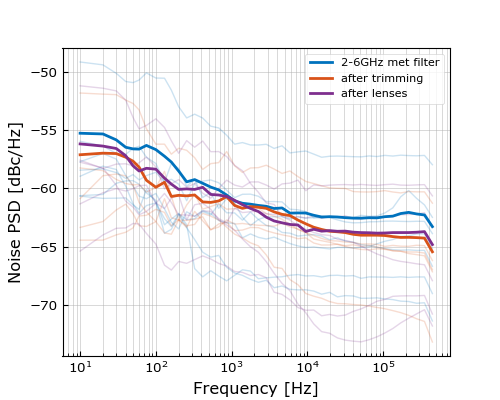

In [7]:
fig, axes = plt.subplot_mosaic('a', sharey=True, figsize=(5,4))
for i, file in enumerate(files):
    fxx, nxx = ft.get_noise_psd(file, wl=100000)
    if not i:
        navg = nxx
        args = np.linspace(0, len(fxx)-1, 3, dtype=int)
    else:
        navg += nxx
    axes['a'].semilogx(fxx, 10*np.log10(nxx), c='b', alpha=0.2)
for i, file in enumerate(files_trim):
    fxx, nxx = ft.get_noise_psd(file, wl=100000)
    if not i:
        navg_trim = nxx
    else:
        navg_trim += nxx
    axes['a'].semilogx(fxx, 10*np.log10(nxx), c='o', alpha=0.2)
for i, file in enumerate(files_lens):
    fxx, nxx = ft.get_noise_psd(file, wl=100000)
    if not i:
        navg_lens = nxx
    else:
        navg_lens += nxx
    axes['a'].semilogx(fxx, 10*np.log10(nxx), c='p', alpha=0.2)
ax = axes['a']
ax.semilogx(fxx, 10*np.log10(navg/len(files)), c='b', lw=2, label='2-6GHz met filter')
ax.semilogx(fxx, 10*np.log10(navg_trim/len(files_trim)), c='o', lw=2, label='after trimming')
ax.semilogx(fxx, 10*np.log10(navg_lens/len(files_lens)), c='p', lw=2, label='after lenses')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Noise PSD [dBc/Hz]')
ax.legend()